# Rapid Landslide Detection using Synthetic Aperture Radar (SAR) Datacubes

## Authors & Contributors
### Notebook
- Alejandro Coca, The Alan Turing Institute (UK), [@acocac](https://github.com/acocac)

### Contributors
- Tina Odaka, Ifremer (France), [@tinaok](https://github.com/tinaok)

### Modelling publication
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "landslide" and not topic % "package"
```

<div class="alert alert-info">
<i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> Overview
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>What is a datacube?</li>
        <li>How do I generate a datacube?</li>
        <li>How optimally train patch-wise deep learning models using the Pangeo stack?</li>
        <li>What is U-Net model?</li>
        <li>How can I use U-Net models for landslide detection?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about Earth Observation datacubes</li>
        <li>Learn about U-Net models for landslide detection</li>
        <li>Learn about xbatcher</li>
    </ul>
</div>

## Context

With the increasing impact of climate change on landslide events, there is a need for rapid landslide detection technologies. Synthetic Aperture Radar (SAR) offers a solution by providing reliable measurements regardless of weather conditions. 

The advancement of deep learning (DL) algorithms for SAR applications is still stalled due to its intricate features and the need for extensive preprocessing. 

Earth Observation datacubes consist of processed data that can be easily utilized by researchers in remote sensing and machine learning fields. Remote sensing scientists can analyze time-series data of specific geographic areas, while machine learning experts can incorporate the data into neural network models in the form of tensors

This notebook demonstrate the added value of analysis-ready SAR datasets to train supervised deep learning models for landslide detection.  

We demonstrate the use of [Dask](https://docs.dask.org/) with [xbatcher](https://github.com/xarray-contrib/xbatcher) to parallelize the generation of the training and test partitions.

### Modelling approach
This notebook applies a U-Net architecture for landslide detection using SAR datacubes. The model is trained over an analysis-ready dataset comprising of SAR intensity and interferometry information, accumulated both before and after disaster events that initiated landslides.

The details of the model are given in the paper entitled "**Deep Learning for Rapid Landslide Detection using Synthetic Aperture Radar (SAR) Datacubes**" {cite:ps}`a-boehm2022`  

### Data

In this episode, we will be using the Hokkaido ARD dataset archived in [Zenodo](https://doi.org/10.5281/zenodo.7248056). The dataset contains multiple layers of SAR time-series data and interferometric products (coherence, InSAR) and auxiliary topographic information (elevation, slope, aspect, curvature) for multiple landslide events along with the corresponding landslide labels as indicated in the image below. 

![SAR Data Cube](images/sar_datacube.png)

In addition to the Hokkaido dataset, there are other analysis-ready datacubes in three geographical areas: Puerto Rico,Mt Talakmau (Indonesia) and Kaikoura (New Zealand).	

All datasets are in [Zarr](https://zarr.dev) format and can be accessed locally through downloading the data from Zenodo or remotely through mirror datasets stored in a MinIO S3 compatible object storage.

## Setup

This episode uses the following main Python packages:

- xarray {cite:ps}`a-xarray-hoyer2017` with [`zarr`](https://pypi.org/project/zarr/) engines
- xbatcher {cite:ps}`a-xbatcher-2024`

Please install these packages if not already available in your Python environment.

### Packages

In this episode, Python packages are imported when we start to use them. However, for best software practices, we recommend you to install and import all the necessary libraries at the top of your Jupyter notebook.

## Load libraries

In [1]:
"""Math & Data Libraries"""
import numpy as np
import xarray as xr
import xbatcher
import s3fs
import pooch
from fsspec.implementations.zip import ZipFileSystem
from fsspec.mapping import FSMap

""" ML Libraries"""
import torch
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchmetrics import AUROC, AveragePrecision, F1Score
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, seed_everything

"""Visualization Libraries"""
import matplotlib.pyplot as plt

""" Miscellaneous Libraries"""
import copy 
from typing import Any, Optional, Tuple, List
from tqdm.notebook import tqdm

## Create a local Dask cluster on the local machine

In [2]:
from dask.distributed import Client

client = Client()   # create `a local dask cluster on the local machine.
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36795,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:33009,Total threads: 2
Dashboard: http://127.0.0.1:34729/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:34561,


## Settings

### Experiments

In [3]:
hparams = {
    "ds_name":"hokkaido_japan",
    "ds_storage":"remote",
    "timestep_length":1,
    "input_vars": "vv_before,vv_after,vh_before,vh_after,dem,dem_aspect,dem_curvature,dem_slope_radians",
    "patch_size": (128, 128),
    "batch_size":64,
    "lr":0.01,
    "weight_decay":0.0001,
    "loss":"ce",
    "max_epochs":30
}

### Data Module

The functions and classes defined below use `xarray` to access the dataset, `xbatcher` to facilitate the generation of patches and `torch.utils.data` modules to define datasets.

In [4]:
def open_zarr_source(ds_name, ds_storage):

    if ds_storage == 'remote':
        fst = s3fs.S3FileSystem(anon=True,
          client_kwargs={
             "endpoint_url": "https://pangeo-eosc-minioapi.vm.fedcloud.eu/"
          })
        
        s3_prefix = 'acocacastro2'
        s3_suffix = 'igarss24'
        s3_bucket = s3_prefix + '-' + s3_suffix + '/'
        
        s3_path = "s3://" + s3_bucket + "/" + ds_name + ".zarr.zip"
        f = fst.open(s3_path)
        fs = ZipFileSystem(f, mode="r")
        store = FSMap("", fs, check=False)
        ds = xr.open_zarr(store=store, consolidated=True)
        
    elif ds_storage == 'local':
        pooch.retrieve(
            url="doi:10.5281/zenodo.7248056/hokkaido_japan.zip",
            known_hash="md5:699b94e827c72bcd69bd786e56bfe5dc",
            processor=pooch.Unzip(extract_dir='data'),
            path=f".",
        )

        ds = xr.open_zarr('data/' + ds_name + '.zarr')
        
    return ds

def before_after_ds(ds_path, ds_storage, ba_vars, aggregation, timestep_length, event_start_date, event_end_date):
    ds = open_zarr_source(ds_path, ds_storage)
    for var in ba_vars:
        ds[var] = np.log(ds[var])
    ds = ds.where(ds['sat:orbit_state'].compute() == 'd', drop=True)
    before_ds = ds.drop_dims('timepair').sel(timestep=slice(None, event_start_date))
    after_ds = ds.drop_dims('timepair').sel(timestep=slice(event_end_date, None))

    if timestep_length < len(before_ds['timestep']):
        before_ds = before_ds.isel(timestep=range(-1 - timestep_length, -1))

    if timestep_length < len(after_ds['timestep']):
        after_ds = after_ds.isel(timestep=range(timestep_length))

    if aggregation == 'mean':
        before_ds = before_ds.mean(dim=('timestep'))
        after_ds = after_ds.mean(dim=('timestep'))
    elif aggregation == 'median':
        before_ds = before_ds.median(dim=('timestep'))
        after_ds = after_ds.median(dim=('timestep'))

    before_after_vars = []
    for suffix in ['before', 'after']:
        for var in ba_vars:
            before_after_vars.append(f'{var}_{suffix}')
    the_ds = before_ds.rename_vars({var: f'{var}_before' for var in ba_vars})
    for var in ba_vars:
        the_ds[f'{var}_after'] = after_ds[var]
    for var in the_ds.data_vars:
        the_ds[f'{var}_mean'] = the_ds[var].mean()
        the_ds[f'{var}_std'] = the_ds[var].std()
    return the_ds.compute().load()


def batching_dataset(ds, patch_size, input_vars, target, include_negatives):
    mean_std_dict = {}
    for var in input_vars:
        if not mean_std_dict.get(var):
            mean_std_dict[var] = {}
        mean_std_dict[var]['mean'] = ds[f'{var}_mean'].values
        mean_std_dict[var]['std'] = ds[f'{var}_std'].values

    batches = []
    bgen = xbatcher.BatchGenerator(ds, {'x': patch_size[0], 'y': patch_size[1]})
    positives = 0
    negatives = 0
    for batch in bgen:
        positives_tmp = batch[target].sum().item()
        if not include_negatives and positives_tmp > 0:
            positives = positives + positives_tmp
            negatives += batch[target].size
            batches.append(batch)
        elif include_negatives and (batch['dem'] <= 0).sum() == 0:
            positives = positives + positives_tmp
            negatives += batch[target].size
            batches.append(batch)
    print(f"P/(P+N)", positives / negatives)
    return batches, mean_std_dict


class BeforeAfterDatasetBatches(Dataset):
    def __init__(self, batches, input_vars, target, mean_std_dict=None):
        print("**************** INIT CALLED ******************")
        self.batches = batches
        self.target = target
        self.input_vars = input_vars
        self.mean = np.stack([mean_std_dict[var]['mean'] for var in input_vars]).reshape((-1, 1, 1))
        self.std = np.stack([mean_std_dict[var]['std'] for var in input_vars]).reshape((-1, 1, 1))

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        batch = self.batches[idx]
        inputs = np.stack([batch[var].values for var in self.input_vars])
        inputs = (inputs - self.mean) / self.std

        target = batch[self.target].values
        inputs = np.nan_to_num(inputs, nan=0)
        target = np.nan_to_num(target, nan=0)
        target = (target > 0)
        return inputs, target


class BeforeAfterCubeDataModule(LightningDataModule):
    """LightningDataModule.

    A DataModule implements 5 key methods:
        - prepare_data (things to do on 1 GPU/TPU, not on every GPU/TPU in distributed mode)
        - setup (things to do on every accelerator in distributed mode)
        - train_dataloader (the training dataloader)
        - val_dataloader (the validation dataloader(s))
        - test_dataloader (the test dataloader(s))

    This allows you to share a full dataset without explaining how to download,
    split, transform and process the data.

    Read the docs:
        https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html
    """

    def __init__(
            self,
            ds_name: str,
            ds_storage: str,
            ba_vars,
            aggregation,
            timestep_length,
            event_start_date,
            event_end_date,
            input_vars,
            target,
            include_negatives=False,
            train_val_test_split: Tuple[float, float, float] = (0.7, 0.2, 0.1),
            patch_size: Tuple[int, int] = (128, 128),
            batch_size: int = 64,
            num_workers: int = 0,
            pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        self.save_hyperparameters(logger=False)

        self.ds = None
        self.batches = None
        self.mean_std_dict = None

        self.data_train: Optional[Dataset] = None
        self.data_val: Optional[Dataset] = None
        self.data_test: Optional[Dataset] = None
        self.data_whole: Optional[Dataset] = None

    def setup(self, stage: Optional[str] = None):
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.

        This method is called by lightning when doing `trainer.fit()` and `trainer.test()`,
        so be careful not to execute the random split twice! The `stage` can be used to
        differentiate whether it's called before trainer.fit()` or `trainer.test()`.
        """
        # load datasets only if they're not loaded already
        if not self.data_train and not self.data_val and not self.data_test:
            self.ds = before_after_ds(self.hparams.ds_name, self.hparams.ds_storage, self.hparams.ba_vars, self.hparams.aggregation,
                                      self.hparams.timestep_length, self.hparams.event_start_date,
                                      self.hparams.event_end_date)
            self.batches, self.mean_std_dict = batching_dataset(self.ds, self.hparams.patch_size, self.hparams.input_vars, self.hparams.target,
                                                                self.hparams.include_negatives)

            dataset = BeforeAfterDatasetBatches(self.batches, self.hparams.input_vars, self.hparams.target,
                                                        mean_std_dict=self.mean_std_dict)

            self.data_whole = dataset

            if self.hparams.train_val_test_split:
                train_val_test_split = [int(len(dataset) * x) for x in self.hparams.train_val_test_split]
                train_val_test_split[2] = len(dataset) - train_val_test_split[1] - train_val_test_split[0]
                train_val_test_split = tuple(train_val_test_split)
                print("*" * 20)
                print("Train - Val - Test SPLIT", train_val_test_split)
                print("*" * 20)
                self.data_train, self.data_val, self.data_test = random_split(
                    dataset=dataset,
                    lengths=train_val_test_split,
                    generator=torch.Generator().manual_seed(42),
                )
    
                print("*" * 20)
                print("Train - Val - Test LENGTHS", len(self.data_train), len(self.data_val), len(self.data_test))
                print("*" * 20)

    def train_dataloader(self):
        return MultiEpochsDataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
            persistent_workers=(self.hparams.num_workers > 0)
        )

    def val_dataloader(self):
        return MultiEpochsDataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
            persistent_workers=(self.hparams.num_workers > 0)
        )

    def test_dataloader(self):
        return MultiEpochsDataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
            persistent_workers=(self.hparams.num_workers > 0)
        )

class MultiEpochsDataLoader(torch.utils.data.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._DataLoader__initialized = False
        self.batch_sampler = _RepeatSampler(self.batch_sampler)
        self._DataLoader__initialized = True
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)


class _RepeatSampler(object):
    """ Sampler that repeats forever.
    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)

### U-Net Model

The class below defines the U-Net architecture using `pl.LightningModule`.

In [5]:
class plUNET(pl.LightningModule):
    def __init__(
            self,
            lr: float = 0.001,
            weight_decay: float = 0.0005,
            num_channels: int = 1,
            loss='dice'
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)
        self.net = smp.UnetPlusPlus(encoder_name='resnet50', in_channels=num_channels, classes=2)

        if loss == 'dice':
            self.criterion = smp.losses.DiceLoss(mode='multiclass')
        elif loss == 'ce':
            self.criterion = torch.nn.CrossEntropyLoss()

        self.train_auc = AUROC(task="binary")
        self.train_f1 = F1Score(task="binary")
        self.train_auprc = AveragePrecision(task="binary")
        self.val_auc = AUROC(task="binary")
        self.val_f1 = F1Score(task="binary")
        self.val_auprc = AveragePrecision(task="binary")
        self.test_auc = AUROC(task="binary")
        self.test_auprc = AveragePrecision(task="binary")
        self.test_f1 = F1Score(task="binary")

        self.train_positive_count = 0
        self.val_positive_count = 0
        self.test_positive_count = 0
        self.train_negative_count = 0
        self.val_negative_count = 0
        self.test_negative_count = 0

    def forward(self, x: torch.Tensor):
        return self.net(x)

    def step(self, batch: Any):
        x, y = batch
        y = y.long()
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.nn.functional.softmax(logits, dim=1)[:, 1]
        return loss, preds, y, x

    def training_step(self, batch: Any, batch_idx: int):
        loss, preds, targets, inputs = self.step(batch)
        self.train_auc.update(preds, targets)
        self.train_auprc.update(preds.flatten(), targets.flatten())
        self.train_f1.update(preds.flatten(), targets.flatten())

        self.log("train/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/auc", self.train_auc, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train/auprc", self.train_auprc, on_step=False, on_epoch=True, prog_bar=False)
        self.log("train/f1", self.train_f1, on_step=False, on_epoch=True, prog_bar=False)
        return {"loss": loss, "preds": preds, "targets": targets, "inputs": inputs}

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch: Any, batch_idx: int):
        loss, preds, targets, _ = self.step(batch)

        # log val metrics
        self.val_auc.update(preds, targets)
        self.val_auprc.update(preds.flatten(), targets.flatten())
        self.val_f1.update(preds.flatten(), targets.flatten())

        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/auc", self.val_auc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/auprc", self.val_auprc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/f1", self.val_f1, on_step=False, on_epoch=True, prog_bar=True)
        return {"loss": loss, "preds": preds, "targets": targets}

    def test_step(self, batch: Any, batch_idx: int):
        loss, preds, targets, _ = self.step(batch)
        self.test_auc.update(preds, targets)
        self.test_auprc.update(preds.flatten(), targets.flatten())
        self.test_f1.update(preds.flatten(), targets.flatten())

        self.log("test/loss", loss, on_step=False, on_epoch=True)
        self.log("test/auc", self.test_auc, on_step=False, on_epoch=True, prog_bar=False)
        self.log("test/auprc", self.test_auprc, on_step=False, on_epoch=True, prog_bar=False)
        self.log("test/f1", self.test_f1, on_step=False, on_epoch=True, prog_bar=False)
        return {"loss": loss, "preds": preds, "targets": targets}

    def on_test_epoch_end(self):
        pass

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            params=self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay
        )
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler, "monitor": "train/loss"}

    def save(self, filename):
        torch.save(self.state_dict(), filename)

    def load(self, filename):
        self.load_state_dict(torch.load(filename))

## Pipeline

### Set a seed ([reproducibility](https://lightning.ai/docs/pytorch/stable/common/trainer.html#reproducibility))

In [6]:
seed_everything(42, workers=True)

Seed set to 42


42

### Define the datacube

In [7]:
hparams["input_vars"] = hparams["input_vars"].split(',')

In [8]:
dm = BeforeAfterCubeDataModule(
    ds_name=hparams["ds_name"],
    ds_storage=hparams["ds_storage"],
    ba_vars=['vv', 'vh'],
    aggregation='mean',
    timestep_length=hparams["timestep_length"],
    event_start_date='20180905',
    event_end_date='20180907',
    input_vars=hparams["input_vars"],
    target='landslides',
    train_val_test_split=(0.7, 0.2, 0.1),
    patch_size=hparams["patch_size"],
    batch_size=hparams["batch_size"],
    include_negatives=False
)

### Initiate the datacube

In [9]:
dm.setup()

P/(P+N) 0.09151421704338593
**************** INIT CALLED ******************
********************
Train - Val - Test SPLIT (216, 61, 32)
********************
********************
Train - Val - Test LENGTHS 216 61 32
********************


## U-Net Model

### Model training

We start defining the model using the `plUNET` class and the hyperparameters defined in the `hparams` dictionary.

In [10]:
model = plUNET(
        lr=hparams["lr"],
        weight_decay=hparams["weight_decay"],
        num_channels=len(hparams["input_vars"]),
        loss=hparams["loss"]
    )

Then we initiate the trainer with the maximum number of epochs defined in the `hparams` dictionary.

In [11]:
trainer = pl.Trainer(max_epochs=hparams["max_epochs"], accelerator="auto")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/srv/conda/envs/notebook/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Finally, we fit the trainer with the model and the datacube.

In [12]:
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name        | Type                   | Params
--------------------------------------------------------
0  | net         | UnetPlusPlus           | 49.0 M
1  | criterion   | CrossEntropyLoss       | 0     
2  | train_auc   | BinaryAUROC            | 0     
3  | train_f1    | BinaryF1Score          | 0     
4  | train_auprc | BinaryAveragePrecision | 0     
5  | val_auc     | BinaryAUROC            | 0     
6  | val_f1      | BinaryF1Score          | 0     
7  | val_auprc   | BinaryAveragePrecision | 0     
8  | test_auc    | BinaryAUROC            | 0     
9  | test_auprc  | BinaryAveragePrecisi

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=116` in the `DataLoader` to improve performance.
/srv/conda/envs/notebook/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=116` in the `DataLoader` to improve performance.
/srv/conda/envs/notebook/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


### Save the trained model

In [13]:
model.save("landslide.pt")

## Model Evaluation

We assess the model performance using the test dataset and the best model checkpoint.

In [14]:
result = trainer.test(ckpt_path="best", datamodule=dm)

Restoring states from the checkpoint path at /home/jovyan/igarss/repos/pangeo-igarss2024/docs/lightning_logs/version_19/checkpoints/epoch=29-step=120.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/jovyan/igarss/repos/pangeo-igarss2024/docs/lightning_logs/version_19/checkpoints/epoch=29-step=120.ckpt
/srv/conda/envs/notebook/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=116` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/auc          │    0.9113519787788391     │
│        test/auprc         │    0.6120477914810181     │
│          test/f1          │            0.0            │
│         test/loss         │    0.2190861701965332     │
└───────────────────────────┴───────────────────────────┘

In [15]:
def vizresults(inputs, prediction, target):
    npinputs = inputs.detach().cpu().numpy()
    npprediction = prediction.detach().cpu().numpy()
    nptarget = target.detach().cpu().numpy()

    f, axarr = plt.subplots(1,10, figsize=(20,5))
    axarr[0].imshow(npprediction)
    axarr[1].imshow(nptarget)

    for i in range(len(hparams["input_vars"])):
        axarr[i+2].imshow(npinputs[i])

In [16]:
# get some random training images
dataiter = iter(dm.test_dataloader())

images, target = next(dataiter)
prediction = model(images).argmax(dim=1)

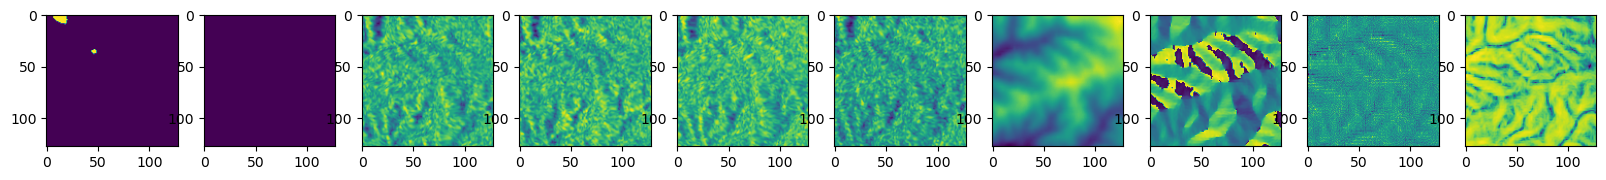

In [17]:
batchid = 0
vizresults(images[batchid],target[batchid],prediction[batchid])

## Prediction over the whole dataset

In [18]:
path = 'landslide.pt'
model = plUNET(
        num_channels=len(hparams["input_vars"]))
model.load_state_dict(torch.load(path))
model.eval()

plUNET(
  (net): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

In [19]:
hparams_all = copy.deepcopy(hparams)
hparams_all['patch_size']=[1024,1024]
hparams_all['batch_size']=1

In [20]:
dm_all= BeforeAfterCubeDataModule(
    ds_name=hparams["ds_name"],
    ds_storage=hparams["ds_storage"],
    ba_vars=['vv', 'vh'],
    aggregation='mean',
    timestep_length=hparams["timestep_length"],
    event_start_date='20180905',
    event_end_date='20180907',
    input_vars=hparams["input_vars"],
    target='landslides',
    train_val_test_split=None,
    patch_size=hparams_all["patch_size"],
    batch_size=hparams_all["batch_size"],
    include_negatives=True
)

In [21]:
dm_all.setup()

P/(P+N) 0.022092103958129883
**************** INIT CALLED ******************


In [22]:
ds = dm_all.data_whole
dataloader = torch.utils.data.DataLoader(ds, pin_memory=False, shuffle=False)

In [23]:
targets = []
outputs = []
for batch_idx, (image, target) in tqdm(enumerate(dataloader), total=len(dataloader)):
    output = model(image)
    outputs.append(output[:, 0].cpu().detach().numpy())
    targets.append(target.cpu().detach().numpy())
    
targets = np.concatenate(targets, axis=0)
outputs = np.concatenate(outputs, axis=0)

  0%|          | 0/20 [00:00<?, ?it/s]

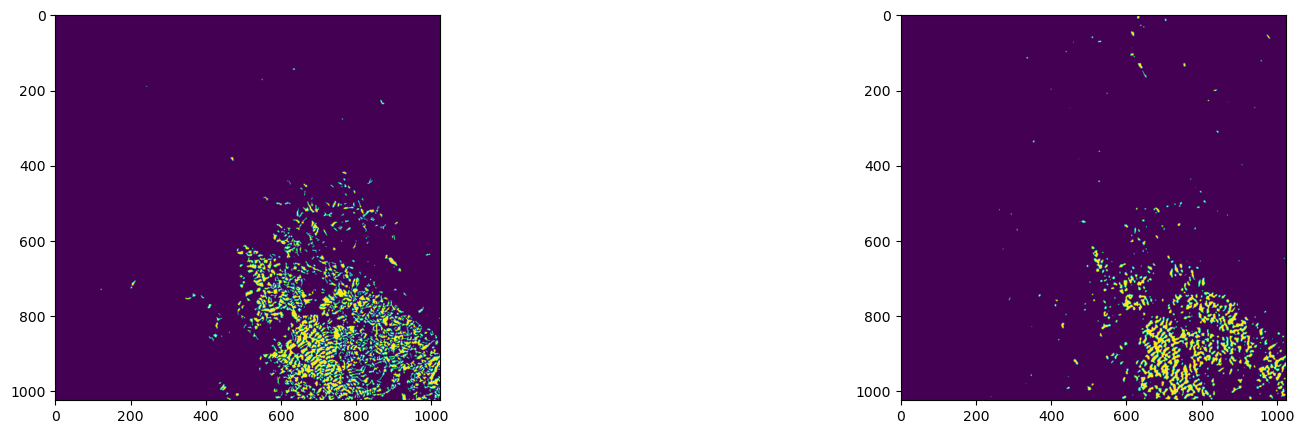

In [24]:
batch_id = 6
f, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].imshow(targets[batch_id])
axarr[1].imshow(outputs[batch_id]<0.5)

 ## References

```{bibliography}
:style: alpha
:filter: topic % "landslide" and not topic % "package"
:keyprefix: a-
```

## Packages citation

```{bibliography}
:style: alpha
:filter: topic % "landslide" and topic % "package"
:keyprefix: a-
```